# Crystal Melting Rates

In [1]:
import numpy as np
import pandas
import altair as alt
import scipy.stats

alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

In [2]:
# Read file with melting data
norm_df = pandas.read_hdf('../data/analysis/melting.h5', 'fractions', mode='r')
norm_df['normed'] = norm_df.volume / norm_df['surface-area']
norm_df.normed.fillna(value=0, inplace=True)

group_bys = ['crystal', 'temperature', 'state', 'pressure']
time_df = norm_df.copy()
time_df.index = pandas.TimedeltaIndex(norm_df.time)
time_df = time_df.groupby(group_bys).resample('1ms').mean().reset_index(group_bys)

df_high = time_df.query('pressure == "13.50"').copy()
df_high = df_high.groupby(group_bys).resample('5ms').mean().reset_index(group_bys)

df_low = norm_df.query('pressure == "1.00"').copy()

In [8]:
def create_figure(temp, dataset):
    c = alt.Chart(dataset.query("temperature == @temp")).mark_line().encode(
        alt.X('time', axis=alt.Axis(format='e', title='Timesteps (t)')),
        alt.Y('percentage:Q', 
            axis=alt.Axis(title='Percentage of Sites (%)'), 
            scale=alt.Scale(domain=[0, 100])),
        alt.Color('state', legend=alt.Legend(title='Classification')),
        alt.Column('crystal', header=alt.Header(title='Initial Crystal')),
        alt.Row('pressure', header=alt.Header(title='Pressure')),
    ).transform_calculate(
        'percentage', 'datum.fraction * 100'
    )
    return c

def compute_melting_rates(df):
    slopes = []
    for index, group in df.groupby(['temperature', 'pressure', 'crystal']):
        # find fraction melted
        subgroup =  group.query('state == "liq" and fraction < 0.95')
        if len(subgroup) < 5:
            break
        slope, *_ = scipy.stats.linregress(subgroup.time, subgroup.normed)
        slopes.append((*index, slope))

    melt = pandas.DataFrame(slopes)
    melt.columns = ['temperature', 'pressure', 'crys', 'melting_rate']
    melt.temperature = melt.temperature.astype(float)
    melt.melting_rate = melt.melting_rate
    return melt

## Low Pressure

In [9]:
temp_select = ToggleButtons(
    options=sorted(df_low.temperature.unique()),
    description='Temperature:',
)

interact(create_figure, temp=temp_select, dataset=fixed(df_low))

NameError: name 'ToggleButtons' is not defined

In [19]:
sorted(df_low.temperature.unique())

['0.30',
 '0.32',
 '0.34',
 '0.35',
 '0.36',
 '0.38',
 '0.40',
 '0.42',
 '0.44',
 '0.45',
 '0.46',
 '0.50',
 '0.60',
 '0.80',
 '1.00',
 '1.20',
 '1.30']

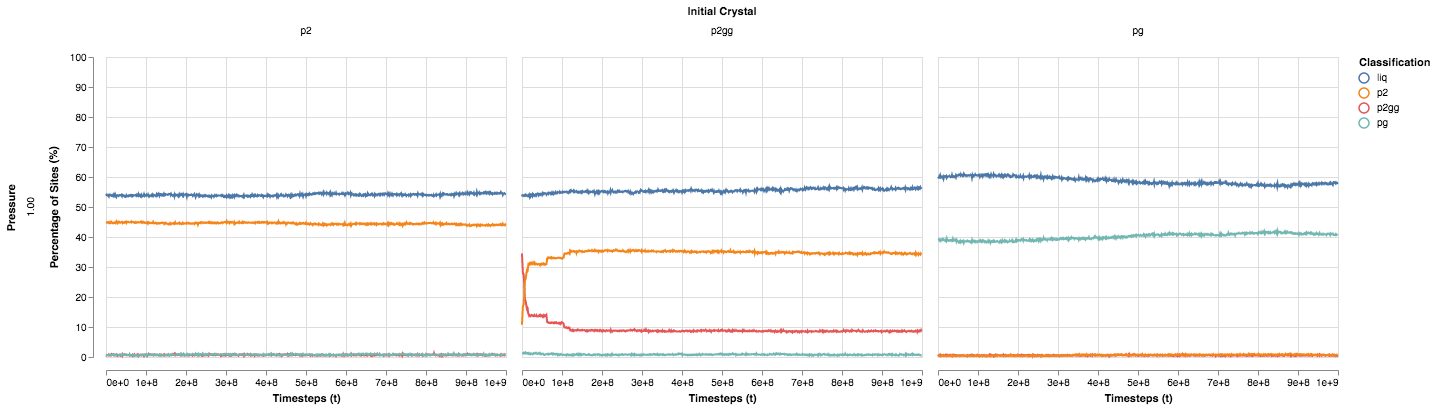

In [22]:
create_figure(temp='0.36', dataset=df_low)

In [5]:
melt_low = compute_melting_rates(df_low)


In [6]:
melt_low

,temperature,pressure,crys,melting_rate
0,0.30,1.00,p2,2.912497e-09
1,0.30,1.00,p2gg,1.537109e-09
2,0.30,1.00,pg,2.475822e-09
3,0.32,1.00,p2,4.030058e-09
4,0.32,1.00,p2gg,-6.809603e-10
5,0.32,1.00,pg,-1.069103e-08
6,0.34,1.00,p2,7.046161e-09
7,0.34,1.00,p2gg,9.691795e-09
8,0.34,1.00,pg,2.682866e-09
9,0.35,1.00,p2,2.442614e-08


In [12]:
alt.Chart(melt_low).mark_line().encode(
    alt.X('temperature', axis=alt.Axis(title='Temperature'), scale=alt.Scale(zero=False)),
    alt.Y('melting_rate', axis=alt.Axis(format='e', title='Melting Rate ((d(V/SA)/dt))')),
    alt.Color('crys', legend=alt.Legend(title='Initial Crystal')),
    alt.Column('pressure', header=alt.Header(title='Pressure')), 
)

## High Pressure

In [96]:
temp_select = ToggleButtons(
    options=sorted(df_high.temperature.unique()),
    description='Temperature:',
)

interact(create_figure, temp=temp_select, dataset=fixed(df_high))

interactive(children=(ToggleButtons(description='Temperature:', options=('1.30', '1.35', '1.40', '1.45', '1.50'), value='1.30'), Output()), _dom_classes=('widget-interact',))

<function __main__.create_figure>

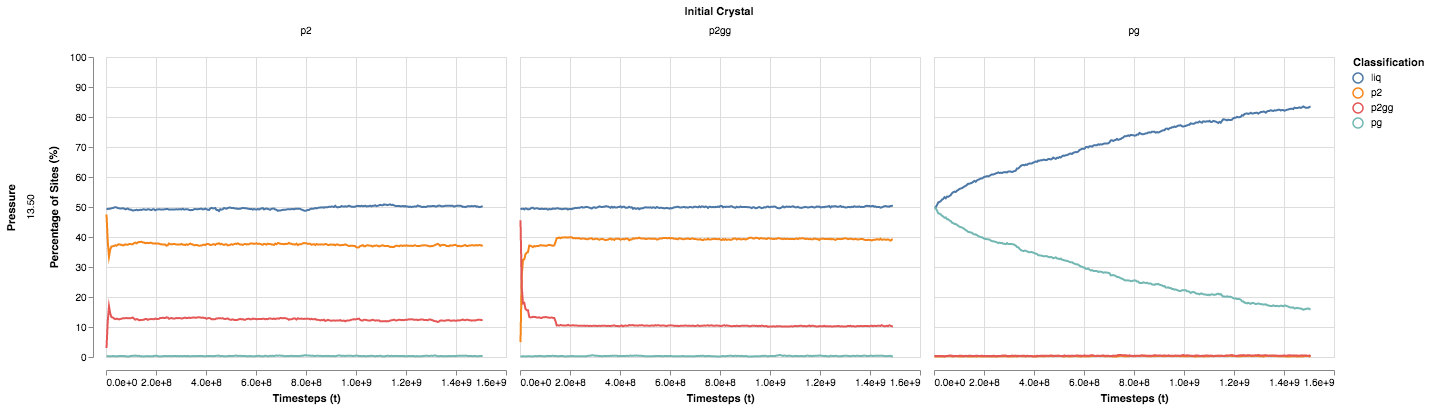

In [15]:
create_figure(temp='1.30', dataset=df_high)

In [14]:
melt_high = compute_melting_rates(df_high)

In [15]:
melt_high

,temperature,pressure,crys,melting_rate
0,1.30,13.50,p2,4.908109e-10
1,1.30,13.50,p2gg,8.041327e-10
2,1.30,13.50,pg,-5.568692e-09
3,1.35,13.50,p2,-1.634369e-09
4,1.35,13.50,p2gg,-2.366232e-10
5,1.35,13.50,pg,-1.613065e-08
6,1.40,13.50,p2,-5.181979e-09
7,1.40,13.50,p2gg,-2.254992e-09
8,1.40,13.50,pg,-3.700425e-08
9,1.45,13.50,p2,-1.297355e-08


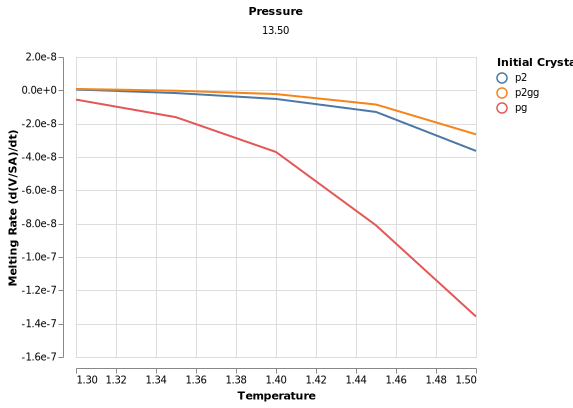

In [98]:
Chart(melt_high).mark_line().encode(
    x=X('temperature', axis=Axis(title='Temperature'), scale=Scale(zero=False)),
    y=Y('melting_rate', axis=Axis(format='e', title='Melting Rate (d(V/SA)/dt)')),
    color=Color('crys', legend=alt.Legend(title='Initial Crystal')),
    column=Column('pressure', header=alt.Header(title='Pressure')), 
)